<a href="https://colab.research.google.com/github/ashikshafi08/PubMed_200k_RCT_Implementation/blob/main/PubMed_200k_RCT_Implementation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PubMed 200k RCT Implementation 

In this notebook we will be replicating the deeplearning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)


**Whats the goal of this dataset ?**

To explore the ability of NLP models to classify sentences which appear in sequential order. In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

>Example inputs (harder to read abstract from PubMed) and outputs (easier to read abstract) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.

#### **Model Input**

For example, can we train an NLP model which takes the following input (note: the following sample has had all numerical symbols replaced with "@"):


#### **Problem in a sentence**
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

#### **Solution in a sentence**

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.


## Getting the data and preprocessing it! 

In [1]:
# Downloading the data 
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed_200K dataset 
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [3]:
# Unzipping the train txt 
!unzip '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip'

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: train.txt               


In [4]:
# Getting the paths of the data 
train_path = 'train.txt'
test_path = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt'
val_path = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt'

Our data is in the format of text files, will write some code to read each of the lines in a tttarget file. 


In [5]:
# Create function to read the lines of a document 
def get_lines(filename):
  '''
  Read filename (a text file) and returns the lines of text as a list. 

  Args: 
    filename : a string containing the target filepath to read 

  Returns:
    A list of strings with one string per line from the target filename.
  '''
  with open(filename , 'r') as f:
    return f.readlines()

In [6]:
# Trying our function out 
train_lines = get_lines(train_path)

# Example's of a abstract 
train_lines[:30]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

Let's write a function to perform the following steps:

- Take a target file of abstract samples.
- Read the lines in the target file.
- For each line in the target file:
  - If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
    - Keep count of the number of lines in a sample.
  - If the line begins with \n mark it as the end of an abstract sample.
    - Keep count of the total lines in a sample.
  - Record the text before the \t as the label of the line.
  - Record the text after the \t as the text of the line.
- Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  - "line_number" - the position of the line in the abstract (e.g. 3).
  - "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  - "text" - the text of the line in the abstract.
  - "total_lines" - the total lines in an abstract sample (e.g. 14).
- Abstract ID's and newlines should be omitted from the returned preprocessed data.


Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

```





In [7]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [8]:
# Getting the data and testing our above function 

train_samples = preprocess_text_with_line_numbers(train_path)
val_samples = preprocess_text_with_line_numbers(val_path)
test_samples = preprocess_text_with_line_numbers(test_path)

# Checking the len
len(train_samples) , len(val_samples) , len(test_samples)

(2211861, 28932, 29493)

In [9]:
# Checking how the abstract of the training data looks like 
train_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'total_lines': 10},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'total_lines': 10},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'total_lines': 10},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'total_lines': 10},
 {'line_number': 4,
  'tar

In [10]:
# For a good representation loading these data into a pandas DataFrame 
import pandas as pd 
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples)


# Looking into the train dataframe 
df_train.head(10)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [11]:
# Distribution of labels in training data
df_train.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

Now we have to convert our samples into a list of sentences, because when we build our deeplearning model one of its main inputs will be a list of strings. 

In [12]:
# Convert abstract text lines into a lists 
train_sentences = df_train['text'].to_list()
val_sentences = df_val['text'].to_list()
test_sentences = df_test['text'].to_list()

len(train_sentences) , len(val_sentences) , len(test_sentences)

(2211861, 28932, 29493)

In [13]:
# Looking into first 10 lines of the training sentences 
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

Now the next step would be making our labels in a numerical format. We will be using `CategoricalCrossEntropy` loss function and it likes to have one hot encoded labels. 

We will use Scikit-learns `OneHotEncoder` and `LabelEncoder` classes. 

In [14]:
# Creating a instance of the  OneHotEncoder
from sklearn.preprocessing import OneHotEncoder 
one_hot_encoder = OneHotEncoder(sparse = False)

# Converting into one hot labels 
train_labels_one_hot = one_hot_encoder.fit_transform(df_train['target'].to_numpy().reshape(-1 , 1))
val_labels_one_hot = one_hot_encoder.fit_transform(df_val['target'].to_numpy().reshape(-1 , 1))
test_labels_one_hot = one_hot_encoder.fit_transform(df_test['target'].to_numpy().reshape(-1 , 1))

# Checking how our training labels look like 
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

Now we will **Label encode labels** so they can be encoded into integers. 

In [15]:
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()

# Making the conversion
train_labels_encoded = label_encoder.fit_transform(df_train['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(df_val['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(df_test['target'].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [16]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments 

In this section we will carry out a handful of modelling experiments such as : 
- `Model 0` --> Baseline Model: TF-IDF Multinomial Naive Bayes
- `Model 1` --> Combining pretrained token embeddings (use embedding) + character embeddings (hybrid embedding layer)
- `Model 2` --> Combining pretrained token embeddings (BERT PUBMED embedding) + character embeddings (hybrid embedding layer)
- `Model 3` --> Combining pretrained token embeddings (GLOVE Embeddings) + character embeddings (hybrid embedding layer)
- `Model 4` --> Tribid model with Positional embedding. 


### Model 0: Baseline Model

In [17]:
# Building TF-IDF model 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating the pipeline 
model_0 = Pipeline([
      ('tf-idf' , TfidfVectorizer()), 
      ('clf' , MultinomialNB())
])

# Fit the pipeline to the training data 
model_0.fit(X = train_sentences , 
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [18]:
# Evaluate the baseline model on our validation dataset 
model_0.score(X = val_sentences , 
              y = val_labels_encoded)

0.7497580533665146

In [19]:
# Making predictions 
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 4, 4, ..., 4, 4, 1])

Writing a function that calculates some of the important metrics for our model

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [21]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [22]:
# Calculating our baseline results 
baseline_results = calculate_results(val_labels_encoded , 
                                     baseline_preds)
baseline_results

{'accuracy': 74.97580533665146,
 'f1': 0.7389570175489825,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146}

Now we have to create token and character level embeddings so we can use these embeddings while building our models. 


#### Creating token embeddings 

In [23]:
# Importing the needed libraries 
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers 
import matplotlib.pyplot as plt


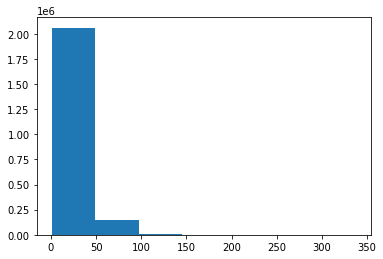

In [24]:
# How long is each sentence on average 
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

# Distribution of the sentence lengths 
plt.hist(sent_lens , bins = 7);

Looks like the vast majority of the sentence are between 0 to 50 tokens in length. 

In [25]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens , 95))

# Maximum sentence length in the training set 
max(sent_lens) , output_seq_len


(338, 54)

Lets create a `TextVectorization` layer and we will keep the parameters default except for `max_tokens` and `output_sequence_length`. 

In [26]:
# Words in the vocabulary (we derive this  from the paper 3.2)
max_tokens = 331000

In [27]:
# Creating the text vectorizer layer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens , 
                                    output_sequence_length = output_seq_len)

# Adapt the text vectorizer to the training sentence 
text_vectorizer.adapt(train_sentences)

It will take approx 9mins to adapt our training sentences to the `TextVectorization` layer. 

In [28]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the impact trial compared the preoperative use of tamoxifen with anastrozole alone or in combination in postmenopausal women ( n = @ ) with primary breast cancer .

Length of text: 28

Vectorized text:
[[   2  365   41   35    2  626   84    3 1779    7 4887  235   15    5
   232    5  756   72   40    7   81  431  170    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [29]:
# Double checking whether the parameters are right!
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 331000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 247961}

Now the next step would be creating a custom Embedding layer. We know that our `text_vectorizer` layer maps the words in our text directly to numbers. To create a richer numerical representation of our text, we can use an `Embedding` layer.

In [30]:
# Create a token embedding layer 
token_embedding = layers.Embedding(input_dim = len(text_vectorizer.get_vocabulary()) , 
                                   output_dim = 128 , 
                                   mask_zero = True ,
                                   name = 'token_embedding_layer')

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the impact trial compared the preoperative use of tamoxifen with anastrozole alone or in combination in postmenopausal women ( n = @ ) with primary breast cancer .

Sentence after vectorization (before embedding):
[[   2  365   41   35    2  626   84    3 1779    7 4887  235   15    5
   232    5  756   72   40    7   81  431  170    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.04223011  0.0498828   0.03165421 ... -0.04383562  0.00688378
    0.04297897]
  [ 0.04528394  0.00164843 -0.04249897 ...  0.0190696  -0.04471027
    0.00900731]
  [ 0.04982716 -0.03944074  0.04427898 ... -0.01235395  0.01853031
    0.00305895]
  ...
  [-0.02634192 -0.01734896 -0.03496151 ... -0.01394435  0.01455059
   -0.02580996]
  [-0.02634192 -0.01734896 -0.03496151 ... -0.01394435  0.01455059
   -0.02580996]
  [-0.02634192 -0.01734896 

Alright cool! Now we have to make a character embedding so that we can load our training sentence as characters. 

#### Creating a character level embedding

In [31]:
# Making a function to split sentences into characters 
def split_chars(text):
  return ' '.join(list(text))

# Trying out the above function on a sequence 
split_chars(train_sentences[0])

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [32]:
# Splitting sequence level data splits into character-level data splits 
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [33]:
# Looking how our train characters look like
print(train_chars[0]) , len(train_chars) , len(train_sentences)

t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .


(None, 2211861, 2211861)

To figure out how long our vectorized character sequences should be, lets check the distribution of our character sequence lengths. 

In [34]:
# Calculating the average length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

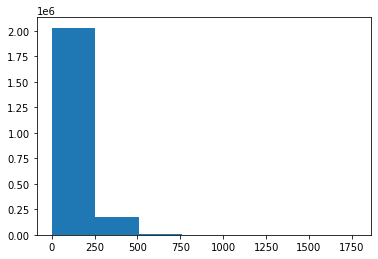

In [35]:
# Check the distribution of our character level 
plt.hist(char_lens, bins=7);

In [36]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

In [37]:
# Get all keyboard characters for char-level embedding 
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
len(train_sentences) , len(train_chars)

(2211861, 2211861)

In [39]:
output_seq_char_len , output_seq_len

(284, 54)

In [40]:
# Create a char-level token vectorizer 
num_char_tokens = len(alphabet) + 2 # space + OOV token = 2 

char_vectorizer = TextVectorization(max_tokens = num_char_tokens , 
                                    output_sequence_length = output_seq_char_len , 
                                    name = 'char_vectorizer')



In [41]:
# Adapt character vectorizer to training characters 
char_vectorizer.adapt(train_chars)

In [43]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")


Charified text:
p r e - t e s t   t e e   s i m u l a t o r   s c o r e s   w e r e   s i m i l a r   b e t w e e n   t h e   t w o   i n s t r u c t i o n   g r o u p s   (   @   v s   @   ;   p   =   @   )   .

Length of chars: 78

Vectorized chars:
[[14  8  2  3  2  9  3  3  2  2  9  5 15 16 11  4  3  7  8  9 12  7  8  2
   9 20  2  8  2  9  5 15  5 11  4  8 22  2  3 20  2  2  6  3 13  2  3 20
   7  5  6  9  3  8 16 12  3  5  7  6 18  8  7 16 14  9 21  9 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

In [44]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=num_char_tokens, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
p r e - t e s t   t e e   s i m u l a t o r   s c o r e s   w e r e   s i m i l a r   b e t w e e n   t h e   t w o   i n s t r u c t i o n   g r o u p s   (   @   v s   @   ;   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-0.03577929  0.03183735  0.04234007 ...  0.00670324 -0.04951379
    0.04789874]
  [-0.03092854 -0.00013926 -0.02975397 ... -0.04448028  0.02656147
   -0.01796294]
  [-0.02903371  0.04619432 -0.04220468 ...  0.0155268  -0.04254328
   -0.02677089]
  ...
  [-0.02248429 -0.04353008 -0.00706393 ...  0.00495217 -0.00899876
   -0.04533676]
  [-0.02248429 -0.04353008 -0.00706393 ...  0.00495217 -0.00899876
   -0.04533676]
  [-0.02248429 -0.04353008 -0.00706393 ...  0.00495217 -0.00899876
   -0.04533676]]]

Character embedding shape: (1, 284, 25)


#### Create positional embeddings 

Since our column `line_number` and `total_line` arre already numerical, we could pass them as they are to our model.

We will use one-hot-encoding to avoid our model thinking a line with `line_number` 5 is five times greater than a line with `line_number` 1. 

Lets figure out the depth parameter so we can use that to one-hot-encoder our features

In [45]:
# How many different line numbers are there?
df_train["line_number"].value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
38         6
39         6
40         6
41         5
42         5
43         5
44         4
45         4
46         3
48         2
49         2
47         2
50         1
Name: line_number, dtype: int64

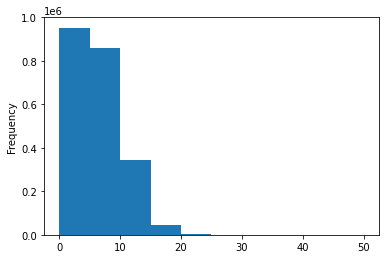

In [50]:
# Check the distribution of "line_number" column
df_train.line_number.plot.hist()

Looking at the distribution of the `line_number` column. It looks like the majority of thhe lines have a position of 15 or less 

In [54]:
# One hot encoding our line_number column 

train_line_numbers_one_hot = tf.one_hot(df_train["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(df_val["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(df_test["line_number"].to_numpy(), depth=15)

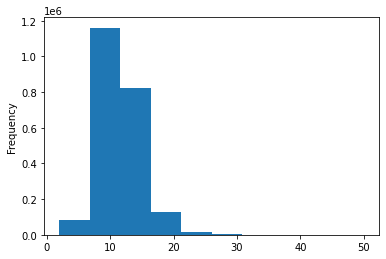

In [52]:
# Check the distribution of total lines
df_train.total_lines.plot.hist();

In [53]:
# Check the coverage of a "total_lines" of 98% distribution
np.percentile(df_train.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [55]:
# One hot encoding the total_lines feature 

train_total_lines_one_hot = tf.one_hot(df_train["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(df_val["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(df_test["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([2211861, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Creating the datasets for fitting the model 


In [64]:
# Create training, validation and test datasets (all four kinds of inputs)

# Training dataset 
train_pos_chars_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot , 
                                                                 train_total_lines_one_hot , 
                                                                 train_sentences ,
                                                                 train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_pos_chars_token_data , train_pos_char_token_labels))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Test Dataset 
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
# Looking into our dataset 
train_dataset , val_dataset , test_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

All done now lets jump into building models 

### Model 1 --> Combining  token embeddings (use  + character embeddings (hybrid embedding layer) + positional embeddings 

In here we will build a tribid model with custom vectorizer and embedding layer for both tokens and characters. 

In [58]:
# Building a custom tribid model (without pretrained embeddings)

# Token Inputs (sentence)
token_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'token_inputs')
token_vectorizer = text_vectorizer(token_inputs)
token_embed = token_embedding(token_vectorizer)
token_bi_lstm = layers.Bidirectional(layers.LSTM(40))(token_embed)
token_model = tf.keras.Model(inputs = token_inputs , 
                             outputs = token_bi_lstm)

# Char-level Inputs (characters)
char_inputs = layers.Input(shape = (1,) , dtype = tf.string , name = 'char_inputs')
char_vectorize = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectorize)
char_bi_lstm = layers.Bidirectional(layers.LSTM(40))(char_embedding)
char_model = tf.keras.Model(inputs = char_inputs ,
                            outputs = char_bi_lstm)


# Positional Embedding (total_lines and line_numbers)
line_num_inputs = layers.Input(shape = (15 ,) , dtype= tf.int32 , name = 'line_number_input')
x = layers.Dense(32 , activation= 'relu')(line_num_inputs)
line_number_model = tf.keras.Model(inputs = line_num_inputs , 
                                   outputs = x)

total_line_inputs = layers.Input(shape = (20 ,) , dtype=tf.int32 , name = 'total_line_input')
y = layers.Dense(32 , activation= 'relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs = total_line_inputs , 
                                  outputs = y)

# Combine character and token emmbedding into a hybrid embedding 
combined_embeddings = layers.Concatenate(name ='token_char_hybrid_embedding')([token_model.output , 
                                                                               char_model.output])

# Adding the needed Dropout (as per in the paper)
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
z = layers.Dense(256 , activation= 'relu')(combined_dropout)


# Combine Positional embeddingw with the hybrid embedding (tribid embedding)
tribid_embedding = layers.Concatenate(name ='char_token_positional_tribid_embedding')([line_number_model.output , 
                                                                                       total_line_model.output , 
                                                                                       z])

# Output layer 
output_layer = layers.Dense(5 , activation= 'softmax' , name ='output_layer')(tribid_embedding)

# Putting everything together 
model_1 = tf.keras.Model(inputs = [line_number_model.input , 
                                   total_line_model.input , 
                                   token_model.input , 
                                   char_model.input] , 
                         outputs = output_layer)

# Sumamry of the model 
model_1.summary()




Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 54)           0           token_inputs[0][0]               
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 284)          0           char_inputs[0][0]                
____________________________________________________________________________________________

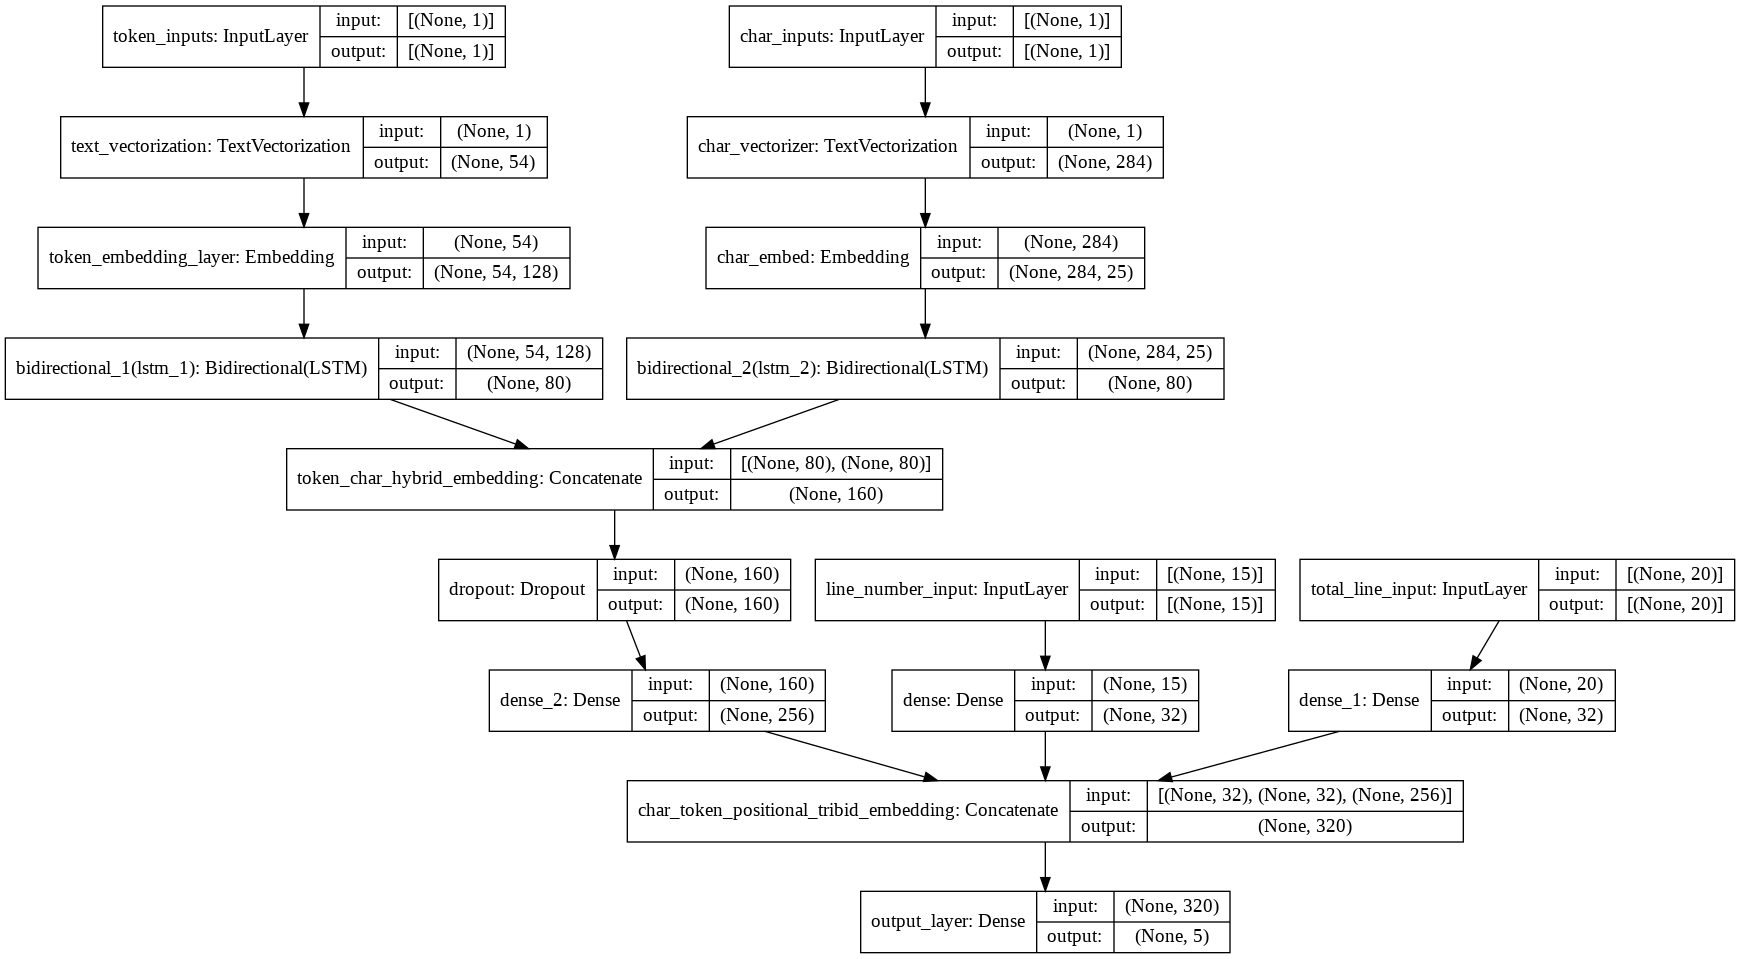

In [59]:
# Plotting the above model 
from tensorflow.keras.utils import plot_model 
plot_model(model_1 , show_shapes = True)

In [60]:
# Compiling the model 
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) , 
                optimizer = tf.keras.optimizers.SGD() ,  # SGD because of the paper
                metrics = ['accuracy'])

In [66]:
# Fitting the model 
history_model_1 = model_1.fit(train_dataset , 
                              steps_per_epoch = len(train_datas et) , 
                              epochs = 5 ,  
                              validation_data = val_dataset , 
                              validation_steps  = int(0.2 * len(val_dataset)))

Epoch 1/5
69121/69121 [==============================] - 3292s 47ms/step - loss: 0.9822 - accuracy: 0.7972 - val_loss: 0.8917 - val_accuracy: 0.8641
Epoch 2/5
69121/69121 [==============================] - 3253s 47ms/step - loss: 0.8946 - accuracy: 0.8606 - val_loss: 0.8711 - val_accuracy: 0.8772
Epoch 3/5
69121/69121 [==============================] - 3254s 47ms/step - loss: 0.8813 - accuracy: 0.8670 - val_loss: 0.8635 - val_accuracy: 0.8826
Epoch 4/5
69121/69121 [==============================] - 3261s 47ms/step - loss: 0.8736 - accuracy: 0.8706 - val_loss: 0.8584 - val_accuracy: 0.8845
Epoch 5/5
69121/69121 [==============================] - 3299s 48ms/step - loss: 0.8686 - accuracy: 0.8731 - val_loss: 0.8560 - val_accuracy: 0.8840


In [67]:
# Saving the model 
model_1.save('model_1/')

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


In [68]:
# from google.colab import drive 
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [69]:
# # Moving the saved model to my Drive 
# !mv 'model_1' '/content/drive/MyDrive/'

In [71]:
# Loading the model 
loaded_model_1 = tf.keras.models.load_model('/content/drive/MyDrive/model_1/')

# Summary of the model 
loaded_model_1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 54)           0           token_inputs[0][0]               
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 284)          0           char_inputs[0][0]                
____________________________________________________________________________________________

In [72]:
for layer in loaded_model_1.layers:
  print(layer.name , layer.dtype)

token_inputs string
char_inputs string
text_vectorization string
char_vectorizer string
token_embedding_layer float32
char_embed float32
bidirectional_1 float32
bidirectional_2 float32
token_char_hybrid_embedding float32
line_number_input int32
total_line_input int32
dropout float32
dense float32
dense_1 float32
dense_2 float32
char_token_positional_tribid_embedding float32
output_layer float32


In [73]:
 # Parsing out the text vectorization layer 
 loaded_text_vectorizer = loaded_model_1.layers[2]
 loaded_text_vectorizer

In [75]:
text_vectorizer.get_config() , loaded_text_vectorizer.get_config()

({'dtype': 'string',
  'max_tokens': 331000,
  'name': 'text_vectorization',
  'ngrams': None,
  'output_mode': 'int',
  'output_sequence_length': 54,
  'pad_to_max_tokens': False,
  'split': 'whitespace',
  'standardize': 'lower_and_strip_punctuation',
  'trainable': True,
  'vocabulary_size': 247961},
 {'dtype': 'string',
  'max_tokens': 331000,
  'name': 'text_vectorization',
  'ngrams': None,
  'output_mode': 'int',
  'output_sequence_length': 54,
  'pad_to_max_tokens': False,
  'split': 'whitespace',
  'standardize': 'lower_and_strip_punctuation',
  'trainable': True,
  'vocabulary_size': 247961})